# Practice Exercise: Scikit-Learn 5
### Pipelines

### Objectives

As part of the [SK5 Tutorial](https://www.featureranking.com/tutorials/machine-learning-tutorials/sk-part-5-advanced-topics-pipelines-statistical-model-comparison-and-model-deployment/), the objective of this practice notebook is to illustrate how you can set up `pipelines` for streamlining your machine learning workflow using `Scikit-Learn`. Pipelines make life easier in relatively large machine learning projects by combining multiple steps in to a single process.

You will be using the cleaned "income data" dataset. In the previous practices, you cleaned and transformed the raw `income data` and renamed the `income` column as `target` (with high income being the positive class). Including `target`, the cleaned data consists of 42 columns and 45,222 rows. Each column is numeric and between 0 and 1.

You will use **stratified 5-fold cross-validation with no repetitions** during training. For testing, you will use the fine-tuned model for prediction **without** any cross-validation for simplicity.

In `GridSearchCV()`, try setting `n_jobs` to -2 for shorter run times with parallel processing. Here, -2 means use all core except 1.

### Exercise 0: Modeling Preparation

- Read in the clean data `us_census_income_data_clean_encoded.csv` on GitHub [here](https://github.com/vaksakalli/datasets). 
- Randomly sample 5000 rows using a random seed of 999.
- Split the sampled data as 70% training set and the remaining 30% test set using a random seed of 999. 
- Remember to separate `target` during the splitting process. 

In [1]:
import numpy as np
np.random.seed(999)

import pandas as pd

# so that we can see all the columns
pd.set_option('display.max_columns', None) 

df = pd.read_csv('us_census_income_data_clean_encoded.csv')

print(df.shape)
df.head().round(3)

(45222, 42)


,age,education_num,race,gender,hours_per_week,native_country,capital,workclass_federal_gov,workclass_local_gov,workclass_private,workclass_self_emp_inc,workclass_self_emp_not_inc,workclass_state_gov,workclass_without_pay,marital_status_divorced,marital_status_married_af_spouse,marital_status_married_civ_spouse,marital_status_married_spouse_absent,marital_status_never_married,marital_status_separated,marital_status_widowed,occupation_adm_clerical,occupation_armed_forces,occupation_craft_repair,occupation_exec_managerial,occupation_farming_fishing,occupation_handlers_cleaners,occupation_machine_op_inspct,occupation_other_service,occupation_priv_house_serv,occupation_prof_specialty,occupation_protective_serv,occupation_sales,occupation_tech_support,occupation_transport_moving,relationship_husband,relationship_not_in_family,relationship_other_relative,relationship_own_child,relationship_unmarried,relationship_wife,target
0,0.301,0.800,1,1,0.398,1,0.063,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,0.452,0.800,1,1,0.122,1,0.042,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0.288,0.533,1,1,0.398,1,0.042,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0.493,0.400,0,1,0.398,1,0.042,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0.151,0.800,0,0,0.398,0,0.042,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


In [2]:
num_samples = 5000
df_sample = df.sample(n=num_samples, random_state=999).reset_index(drop=True)
df_sample.shape

(5000, 42)

In [3]:
from sklearn.model_selection import train_test_split
target = df_sample['target']
Data_df = df_sample.drop(columns = 'target')
D_train, D_test, t_train, t_test = train_test_split(Data_df.values, 
                                                    target.values, 
                                                    test_size=0.3, 
                                                    random_state=999)

In [4]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV

cv_method = StratifiedKFold(n_splits=5, shuffle=True, random_state=999)

### Exercise 1: Pipeline Preparation

For feature selection, you will use the powerful Random Forest Importance (RFI) method with 100 estimators. A trick here is that you will need a bit of coding so that you can make RFI feature selection as part of the pipeline. For this reason, we are providing for you the custom `RFIFeatureSelector()` class below to pass in RFI as a "step" to the pipeline.
```Python
from sklearn.base import BaseEstimator, TransformerMixin
# custom function for RFI feature selection inside a pipeline
# here we use n_estimators=100
# notice the random_state in RandomForestClassifier()
# to control randomness
class RFIFeatureSelector(BaseEstimator, TransformerMixin):
    # class constructor 
    # make sure class attributes end with a "_"
    # per scikit-learn convention to avoid errors
    def __init__(self, n_features_=10):
        self.n_features_ = n_features_
        self.fs_indices_ = None
        self.fs_importance_ = None
    # override the fit function
    def fit(self, X, y):
        from sklearn.ensemble import RandomForestClassifier
        from numpy import argsort
        model_rfi = RandomForestClassifier(n_estimators=100, random_state=999)
        model_rfi.fit(X, y)
        self.fs_indices_ = argsort(model_rfi.feature_importances_)[::-1][0:self.n_features_]
        self.fs_importance_ = model_rfi.feature_importances_[self.fs_indices_ ]
        return self 
    # override the transform function
    def transform(self, X, y=None):
        return X[:, self.fs_indices_]
```

We are also making available the custom function below, called `get_search_results()`, which will format outputs of an input grid search object as a `Pandas` data frame.
```Python
# custom function to format the search results as a Pandas data frame
def get_search_results(gs):
    def model_result(scores, params):
        scores = {'mean_score': np.mean(scores),
             'std_score': np.std(scores),
             'min_score': np.min(scores),
             'max_score': np.max(scores)}
        return pd.Series({**params,**scores})
    models = []
    scores = []
    for i in range(gs.n_splits_):
        key = f"split{i}_test_score"
        r = gs.cv_results_[key]        
        scores.append(r.reshape(-1,1))
    all_scores = np.hstack(scores)
    for p, s in zip(gs.cv_results_['params'], all_scores):
        models.append((model_result(s, p)))
    pipe_results = pd.concat(models, axis=1).T.sort_values(['mean_score'], ascending=False)
    columns_first = ['mean_score', 'std_score', 'max_score', 'min_score']
    columns = columns_first + [c for c in pipe_results.columns if c not in columns_first]
    return pipe_results[columns]
```

You will need to copy and paste these two code blocks before you can continue with the next exercise.

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin
# custom function for RFI feature selection inside a pipeline
# here we use n_estimators=100
# notice the random_state in RandomForestClassifier()
# to control randomness
class RFIFeatureSelector(BaseEstimator, TransformerMixin):
    # class constructor 
    # make sure class attributes end with a "_"
    # per scikit-learn convention to avoid errors
    def __init__(self, n_features_=10):
        self.n_features_ = n_features_
        self.fs_indices_ = None
        self.fs_importance_ = None
        
    # override the fit function
    def fit(self, X, y):
        from sklearn.ensemble import RandomForestClassifier
        from numpy import argsort
        model_rfi = RandomForestClassifier(n_estimators=100, random_state=999)
        model_rfi.fit(X, y)
        self.fs_indices_ = argsort(model_rfi.feature_importances_)[::-1][0:self.n_features_] 
        self.fs_importance_ = model_rfi.feature_importances_[self.fs_indices_ ]
        return self 
    # override the transform function
    def transform(self, X, y=None):
        return X[:, self.fs_indices_]

In [6]:
# custom function to format the search results as a Pandas data frame
def get_search_results(gs):
    def model_result(scores, params):
        scores = {'mean_score': np.mean(scores),
             'std_score': np.std(scores),
             'min_score': np.min(scores),
             'max_score': np.max(scores)}
        return pd.Series({**params,**scores})
    models = []
    scores = []
    for i in range(gs.n_splits_):
        key = f"split{i}_test_score"
        r = gs.cv_results_[key]        
        scores.append(r.reshape(-1,1))
    all_scores = np.hstack(scores)
    for p, s in zip(gs.cv_results_['params'], all_scores):
        models.append((model_result(s, p)))
    pipe_results = pd.concat(models, axis=1).T.sort_values(['mean_score'], ascending=False)
    columns_first = ['mean_score', 'std_score', 'max_score', 'min_score']
    columns = columns_first + [c for c in pipe_results.columns if c not in columns_first]
    return pipe_results[columns]

### Exercise 2

Using a pipeline, stack Random Forest Importance (RFI) feature selection together with grid search for DT hyperparameter tuning via cross-validation using the **train** data. For scoring, use AUC, that is, "area under the ROC curve". 

For RFI, consider number of features in {10, 20, full_number_of_descriptive_features}.

For the DT model, aim to determine the optimal combinations of maximum depth (`max_depth`) and minimum sample split (`min_samples_split`) using the **Gini Index** split criterion. In particular, consider max_depth values in {3, 5, 7, 9, 11} and min_samples_split values in {2, 5, 7, 9, 11}.

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

pipe_DT = Pipeline([('rfi_fs', RFIFeatureSelector()),
                    ('dt', DecisionTreeClassifier(criterion='gini', random_state=999))])

params_pipe_DT = {'rfi_fs__n_features_': [10, 20, Data_df.shape[1]],
                  'dt__max_depth': [3, 5, 7, 9, 11],
                  'dt__min_samples_split': [2, 5, 7, 9, 11]}

scoring_metric = 'roc_auc'

gs_pipe_DT = GridSearchCV(estimator=pipe_DT, 
                          param_grid=params_pipe_DT, 
                          cv=cv_method,
                          refit=True,
                          n_jobs=-2,
                          scoring=scoring_metric,
                          verbose=1) 

gs_pipe_DT.fit(D_train, t_train);

Fitting 5 folds for each of 75 candidates, totalling 375 fits


### Exercise 3

Display the pipeline best parameters, the best score, and the best estimator. 

In [8]:
gs_pipe_DT.best_params_

{'dt__max_depth': 7, 'dt__min_samples_split': 5, 'rfi_fs__n_features_': 10}

In [9]:
gs_pipe_DT.best_score_

0.8850942182611139

In [10]:
gs_pipe_DT.best_estimator_

Pipeline(steps=[('rfi_fs', RFIFeatureSelector()),
                ('dt',
                 DecisionTreeClassifier(max_depth=7, min_samples_split=5,
                                        random_state=999))])

In [11]:
print(f'The best model has 10 features, maximum depth of 7 and minimum split value of 9.')

The best model has 10 features, maximum depth of 7 and minimum split value of 9.


### Exercise 4

Using the custom `get_search_results()` function, display the top 5 combinations of the pipeline.

In [12]:
results_DT = get_search_results(gs_pipe_DT)
results_DT.head()

,mean_score,std_score,max_score,min_score,dt__max_depth,dt__min_samples_split,rfi_fs__n_features_
33,0.885094,0.010217,0.898146,0.869979,7.0,5.0,10.0
36,0.884980,0.010387,0.898146,0.869407,7.0,7.0,10.0
43,0.884579,0.010376,0.899033,0.871095,7.0,11.0,20.0
37,0.884425,0.011223,0.898542,0.870182,7.0,7.0,20.0
42,0.884149,0.008905,0.895871,0.872019,7.0,11.0,10.0


### Exercise 5

Visualize DT performance comparison results by filtering the output of the `get_search_results()` function for 10 features. Put minimum samples for split in the x-axis, AUC in the y-axis and break down the plot by maximum depth.

In [13]:
results_DT_10_features = results_DT[results_DT['rfi_fs__n_features_'] == 10.0]
results_DT_10_features.to_csv('results_DT_10_features.csv')

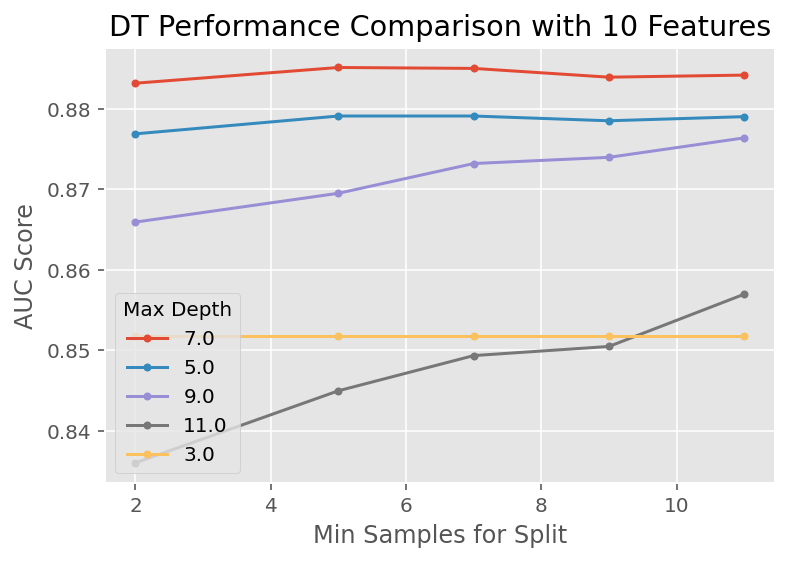

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
plt.style.use("ggplot")

for i in results_DT_10_features['dt__max_depth'].unique():
    temp = results_DT_10_features[results_DT_10_features['dt__max_depth'] == i]
    temp = temp.sort_values('dt__min_samples_split')
    plt.plot(temp['dt__min_samples_split'], temp['mean_score'], marker = '.', label = i)
    
plt.legend(title = 'Max Depth')
plt.xlabel('Min Samples for Split')
plt.ylabel("AUC Score")
plt.title("DT Performance Comparison with 10 Features")
plt.show()


### Exercise 6

Using the best estimator of the pipeline, obtain the predictions on the **test** data. Display the confusion matrix and the AUC score on this test data. 

Next, using the best estimator of the pipeline, obtain the predictions on the **train** data. Display the confusion matrix and the AUC score on this train data. 

How does the test AUC compare to the train AUC? Why do you think there is difference?

In [15]:
from sklearn import metrics

# clf_best has been fitted on the entire train data by Scikit-Learn!
clf_best = gs_pipe_DT.best_estimator_

t_pred = clf_best.predict(D_test)

print(metrics.confusion_matrix(t_test, t_pred))

test_AUC = metrics.roc_auc_score(t_test, t_pred)
test_AUC

[[1066   59]
 [ 171  204]]


0.7457777777777779

In [16]:
clf = gs_pipe_DT.best_estimator_

t_pred = clf.predict(D_train)

print(metrics.confusion_matrix(t_train, t_pred))

train_AUC = metrics.roc_auc_score(t_train, t_pred)
train_AUC

[[2452  146]
 [ 376  526]]


0.7634757420427447

In [17]:
print('Train AUC is slightly higher compared to Test AUC due to slight overfitting during training.')

Train AUC is slightly higher compared to Test AUC due to slight overfitting during training.


## Optional: Extracting selected features in the pipeline

We have implemented a customized feature selector in the pipeline. So, how we can extract the feature importance from the fitted grid-search model? We can call the "fitted selector" from `best_estimator_.named_steps` as follow. The fitted selector (named as `selected_features`) is an `RFIFeatureSelector` object fitted on the training data. The `RFIFeatureSelector` object contains two attributes: `fs_indices_` and `fs_importance_`. `fs_indices_` contains an array of the selected feature indices whereas `fs_importance_` is the importance values of the selected features. 

In [18]:
selected_features = gs_pipe_DT.best_estimator_.named_steps["rfi_fs"]
fs_names = Data_df.columns[selected_features.fs_indices_].tolist()
fs_names

['age',
 'education_num',
 'capital',
 'hours_per_week',
 'marital_status_married_civ_spouse',
 'relationship_husband',
 'occupation_exec_managerial',
 'occupation_prof_specialty',
 'marital_status_never_married',
 'race']

In [19]:
selected_features.fs_importance_

array([0.21247653, 0.13483194, 0.12875423, 0.10715129, 0.08796469,
       0.04213264, 0.02422104, 0.02199722, 0.02037863, 0.0151604 ])

In [20]:
fs_results = pd.DataFrame({"Feature": fs_names, 
                           "Importance": selected_features.fs_importance_})
fs_results 

,Feature,Importance
0,age,0.212477
1,education_num,0.134832
2,capital,0.128754
3,hours_per_week,0.107151
4,marital_status_married_civ_spouse,0.087965
5,relationship_husband,0.042133
6,occupation_exec_managerial,0.024221
7,occupation_prof_specialty,0.021997
8,marital_status_never_married,0.020379
9,race,0.015160


How about the scikit "in-house" feature selector say `SelectKBest`? Let's re-run the pipeline with a `SelectKBest` selector.


In [21]:
from sklearn.feature_selection import SelectKBest, f_classif
pipe_DT_kbest = Pipeline([('fs', SelectKBest(f_classif)),
                         ('dt', DecisionTreeClassifier(criterion='gini', random_state=999))])

params_pipe_DT_kbest  = {'fs__k': [10, 20, Data_df.shape[1]],
                         'dt__max_depth': [3, 5, 7, 9, 11],
                         'dt__min_samples_split': [2, 5, 7, 9, 11]}

scoring_metric = 'roc_auc'

gs_pipe_DT_kbest = GridSearchCV(estimator=pipe_DT_kbest, 
                                param_grid=params_pipe_DT_kbest, 
                                cv=cv_method,
                                refit=True,n_jobs=-2,
                                scoring=scoring_metric,
                                verbose=1) 

gs_pipe_DT_kbest.fit(D_train, t_train);

Fitting 5 folds for each of 75 candidates, totalling 375 fits


After fitting on the `SelectKBest` selector, we can invoke `get_support()` method to obtain a "Boolean" list indicating which features are selected. The selector also contains `scores_` - which ranks the features. With the details, we can know which features are selected.

In [22]:
kbest_selector = gs_pipe_DT_kbest.best_estimator_.named_steps['fs']
kbest_index = kbest_selector.get_support()
kbest_score = kbest_selector.scores_
kbest_results = pd.DataFrame({"Feature": Data_df.columns.tolist(),
                              "Selected": kbest_index,
                              "Score": kbest_score})
kbest_results[kbest_results['Selected']]

,Feature,Selected,Score
0,age,True,209.496983
1,education_num,True,439.706201
3,gender,True,175.120308
4,hours_per_week,True,172.394693
6,capital,True,169.852484
9,workclass_private,True,38.462018
10,workclass_self_emp_inc,True,60.520582
14,marital_status_divorced,True,57.728015
16,marital_status_married_civ_spouse,True,863.384696
18,marital_status_never_married,True,395.390961


***
www.featureranking.com